In [3]:
import numpy as np
import sympy

from PIL import Image
from imageio import imread

import matplotlib.pyplot as plt

In [4]:
class SV:
    def __init__(self, x_ind):
        self.lower_bound = 0
        self.lower_reach_flg = 1
        self.unkwn_for_reach_lb = np.array([[]] * len(x_ind))
        
        self.upper_bound = None
        self.upper_reach_flg = 0
        self.unkwn_for_reach_ub = np.array([[]] * len(x_ind))
        
    def check_bound(self, A, type_bnd):
        # if from_flg then lower_bound = lower_bound(C -- right)
        # else lower_bound = lower_bound(B -- left -- lower)
        #
        # type_bnd = 'lower' or 'upper'
        
        if type_bnd == "lower":
            sigma = self.lower_bound
            if sigma is None:
                self.unkwn_for_reach_lb = 0
                return
        else:
            sigma = self.upper_bound
            if sigma is None:
                self.unkwn_for_reach_ub = 0
                return
        
        print(type_bnd)
        
        c = A.A[1: , 0 ].reshape((-1, 1))
        r = A.A[0  , 1:].reshape((-1, 1))
        K = A.A[1: , 1:]
        L = c.dot(c.T) + K.dot(K.T) - sigma**2 * np.identity(c.shape[0])
        
        a = np.linalg.det(np.block([[1, c.T], [c, L]]))
        b = np.linalg.det(2 * np.block([[0, r.T.dot(K.T)], [c, L]]))
        c = np.linalg.det(np.block([[r.T.dot(r) - sigma**2, r.T.dot(K.T)], [K.dot(r), L]]))
        
        if abs(a) < 10**(-6):
            if abs(b) < 10**(-6):
                if abs(c) >= 10**(-6):
                    if type_bnd == "lower":
                        self.lower_reach_flg = 0
                    else:
                        self.upper_reach_flg = 0
                    print("No solution, a=b=0, c<>0")
                else:
                    if type_bnd == "lower":
                        self.lower_reach_flg = 1
                    else:
                        self.upper_reach_flg = 1
                    print("x - any, a=b=c=0")
            else:
                if type_bnd == "lower":
                    self.lower_reach_flg = 1
                else:
                    self.upper_reach_flg = 1
                print("x = ", -c/b, " a=0 b<>0")
        else:
            D = b * b - 4 * a * c
            print("We here: a=",a," b=", b, " c=", c, " D=", D)
            if abs(D) < 10**(-6):
                if type_bnd == "lower":
                    self.lower_reach_flg = 1
                else:
                    self.upper_reach_flg = 1
                x = -b/a
                print("x_1 = x_2 =", x)
            elif D < 0:
                if type_bnd == "lower":
                    self.lower_reach_flg = 0
                else:
                    self.upper_reach_flg = 0
                print("No solution, a<>0 D<0")
            else:
                if type_bnd == "lower":
                    self.lower_reach_flg = 1
                else:
                    self.upper_reach_flg = 1
                x_1 = 1/2 * (-b + np.sqrt(D))
                x_2 = 1/2 * (-b - np.sqrt(D))
                print("x_1 = ", x_1, " x_2 = ", x_2)

In [5]:
class Partially_prescribed_matrix:
    def __init__(self, A, x_ind):
        self.A = A.copy()
        self.x_ind = x_ind.copy()
        self.x_ind.sort(key=lambda elem: elem[0] * max(np.array(self.A).shape) + elem[1])
        
        self.sv_fnd_flg = False
        self.sv = [SV(x_ind) for x in range(min(A.shape))]
            
    def print_M(self):
        print("--------PP Matrix--------")
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                if [i, j] in self.x_ind:
                    print("x", end=" ")
                else:
                    print(self.A[i, j], end=" ")
            print(end="\n")
        print("-------------------------")
        
    def print_sv(self):
        if self.sv_fnd_flg == False:
            self.find_sv()
        for i in range(len(self.sv)):
            print("Номер сингулярного числа:", i, "\n  ", self.sv[i].lower_bound, "<", end="")
            if self.sv[i].lower_reach_flg == 1:
                print("= ", end="")
            else:
                print("  ", end="")
            print("s ", end="")
            if self.sv[i].upper_bound is not None:
                print("<", end="")
                if self.sv[i].upper_reach_flg == 1:
                    print("= ", end="")
                else:
                    print("  ", end="")
                print(self.sv[i].upper_bound, end="")
            print(end="\n\n")
    
    # Меняем i-ую строку на нулевую и наоборот
    # Меняем j-ый столбец на нулевой и наоборот
    # elem = (i, j)
    def change_row_column(self, elem):
        A_ = self.A.copy()
        self.A[0] = A_[elem[0]]
        self.A[elem[0]] = A_[0]
        
        A_ = self.A.copy()
        self.A[:, 0] = A_[:, elem[1]]
        self.A[:, elem[1]] = A_[:, 0]       
        
    
    # Перемещаем какой-нибудь неизвестный элемент на (0,0) место
    def move_x(self):
        if len(self.x_ind) == 0:
            return 0
        f_elem = self.x_ind[0].copy()
        self.change_row_column(f_elem)
        for elem in self.x_ind:
            if elem[0] == f_elem[0]:
                elem[0] = 0
            if elem[1] == f_elem[1]:
                elem[1] = 0
        return 1
    
    # Делим матрицу на две, удаляя первую строку или первый столбец
    def div_matrix(self):
        left = Partially_prescribed_matrix(self.A[1:], (np.array(self.x_ind) - [1, 0]).tolist())
        for i in range(np.array(left.A).shape[1]):
            try:
                left.x_ind.remove([-1, i])
            except Exception:
                1
        right = Partially_prescribed_matrix(self.A[:, 1:], (np.array(self.x_ind) - [0, 1]).tolist())
        for i in range(np.array(right.A).shape[0]):
            try:
                right.x_ind.remove([i, -1])
            except Exception:
                1
        return left, right
    
    # Выполняет алгоритм, описанный в курсовой
    def find_sv(self):
        self.sv_fnd_flg = True
        
        for ind in self.x_ind:
            self.A[ind[0], ind[1]] = 0
            
        n = min(np.array(self.A).shape)
        
        if len(self.x_ind) == 0:
            values = np.linalg.svd(self.A)[1].tolist()
            for i in range(len(values)):
                self.sv[i].lower_bound = values[i]
                self.sv[i].lower_reach_flg = 1
                self.sv[i].upper_bound = values[i]
                self.sv[i].upper_reach_flg = 1
            return self.sv
        
        if n == 1:
            self.sv[0].lower_bound = np.sum(self.A)
            self.sv[0].lower_reach_flg = 1
            self.sv[0].unkwn_for_reach_lb = np.array([[0]] * len(self.x_ind))
            return self.sv
        
        self.move_x()
        
        left, right = self.div_matrix()
        l_sv = left.find_sv()
        r_sv = right.find_sv()
        left.print_M()
        left.print_sv()
        right.print_M()
        right.print_sv()
        
        for i in range(min(len(l_sv), len(r_sv))):
            self.sv[i].lower_bound = max(l_sv[i].lower_bound, r_sv[i].lower_bound)
            self.sv[i].check_bound(self, "lower")
            
            if l_sv[i].upper_bound is None:
                self.sv[i + 1].upper_bound = r_sv[i].upper_bound
            elif r_sv[i].upper_bound is None:
                self.sv[i + 1].upper_bound = l_sv[i].upper_bound
            else:
                self.sv[i + 1].upper_bound = min(l_sv[i].upper_bound, r_sv[i].upper_bound)
                
            self.sv[i + 1].check_bound(self, "upper")

        if len(l_sv) > len(r_sv):
            self.sv[len(r_sv)].lower_bound = l_sv[len(r_sv)].lower_bound
            self.sv[len(r_sv)].check_bound(self, "lower")
        elif len(l_sv) < len(r_sv):
            self.sv[len(l_sv)].lower_bound = r_sv[len(l_sv)].lower_bound
            self.sv[len(l_sv)].check_bound(self, "lower")
        else:
            self.sv[len(l_sv)].lower_bound = 0
            self.sv[len(l_sv)].check_bound(self, "lower")
        
        return self.sv

In [28]:
values1 = []
values2 = []

for i in range(-10**3, 10**3):
    x = i
    _, sv, _ = np.linalg.svd(np.array([[x, 1, 0], [1, 1, 0], [0, 0, 1]]))
    values1.append(sv[0])
    values2.append(sv[1])
    
A_matrix = Partially_prescribed_matrix(np.array([[x, 1], [1, 0]]), [[0, 0]])
sv_M = A_matrix.find_sv()

--------PP Matrix--------
1 0 
-------------------------
Номер сингулярного числа: 0 
   1.0 <= s <= 1.0

--------PP Matrix--------
1 
0 
-------------------------
Номер сингулярного числа: 0 
   1.0 <= s <= 1.0

lower
We here: a= -1.0  b= 0.0  c= 0.0  D= 0.0
x_1 = x_2 = 0.0
upper
We here: a= -1.0  b= 0.0  c= 0.0  D= 0.0
x_1 = x_2 = 0.0
lower
No solution, a=b=0, c<>0


Номер сингулярного числа: 0 
   1.0 <= s 

Номер сингулярного числа: 1 
   0 <  s <= 1.0

При подстановке конкретных значений:
Найденное минимальное значение (1): 1.4142135623730951 
Найденное максимальное значение (1): 1000.0009990000019 

Найденное минимальное значение (0): 1.0 
Найденное максимальное значение (0): 1.414213562373095


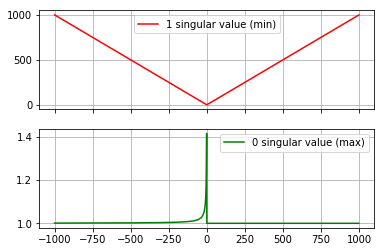

In [29]:
#print("Согласно реализованному алгоритму:")
#print("Нижние границы на сингулярные значения: ", min_sv)
#print("Верхние границы на сингулярные значения:", max_sv, "\n")
A_matrix.print_sv()

print("При подстановке конкретных значений:")
print("Найденное минимальное значение (1):", min(values1), "\nНайденное максимальное значение (1):", max(values1), "\n")
print("Найденное минимальное значение (0):", min(values2), "\nНайденное максимальное значение (0):", max(values2))

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(range(-10**3, 10**3), values1, color='r', label="1 singular value (min)")
ax2.plot(range(-10**3, 10**3), values2, color='g', label="0 singular value (max)")

ax1.legend()
ax1.grid(True)

ax2.legend()
ax2.grid(True)

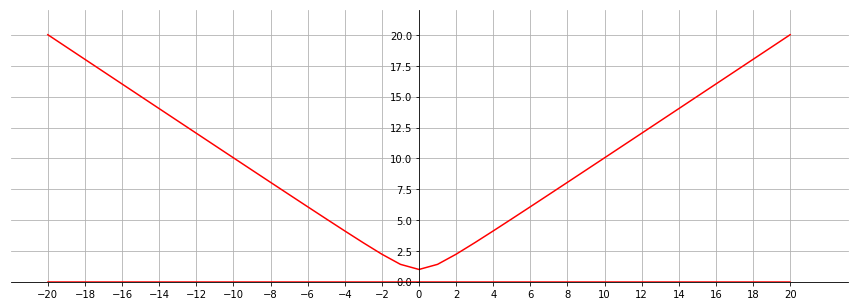

In [27]:
f = plt.figure(figsize=(15,5))
plt.plot(range(-20, 21), values1[980:1021], color='r', label="1 singular value (min)")
plt.plot(range(-20, 21), values2[980:1021], color='r', label="1 singular value (min)")
plt.grid(True)

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',0))

plt.xlim(-20 * 1.1, 21 * 1.1)
plt.xticks(range(-20, 21, 2))

plt.ylim(0 * 1.1, max(values1[980:1021]) * 1.1)
#plt.yticks([round(x/10, 1) for x in range(0, 11, 2)])

plt.show()
f.savefig("example4_01.pdf")

In [ ]:
\par
\textit{Теорема. }
\par
\textit{
Пусть
$$
M =
\begin{pmatrix}
x & \vline & v^T \\
\hline
u & \vline & A
\end{pmatrix} \in \RR^{(k + 1) \times (n + 1)},\ 
B = \begin{pmatrix} u    & A \end{pmatrix},\ 
C = \begin{pmatrix} v^T \\ A \end{pmatrix},
$$
а $\sigma_1 \geq \sigma_2 \geq \ldots \geq \sigma_{k+1}$ --- сингулярные числа матрицы $M$, $s_1 \geq s_2 \geq \ldots \geq s_k$ --- сингулярные числа матрицы $B$, $s_1' \geq s_2' \geq \ldots \geq s_{k+1}'$ --- сингулярные числа матрицы $C$, $\bar{s}_1 \geq \bar{s}_2 \geq \ldots \geq \bar{s}_k$ --- сингулярные числа матрицы $A$.
\\
Пусть также числа $s_p,\ s_p',\ s_{p - 1},\ s_{p - 1}',\ \bar{s}_p$ и $\bar{s}_{p-1}$ попарно различны и $s \in \RR$ --- такое число, что
$$
max\{s_p, s_p'\} \leq s \leq min\{s_{p - 1}, s_{p - 1}'\}.
$$
Тогда существует такой $x$, что матрица $M$ имеет число $s$ в качестве своего $p$-го сингулярного числа.
\\
Более того существует единственный $x$ такой, что матрица $M$ имеет число $max\{s_p, s_p'\}$ в качестве своего $p$-го сингулярного значения.}\\

(481, 770, 3)


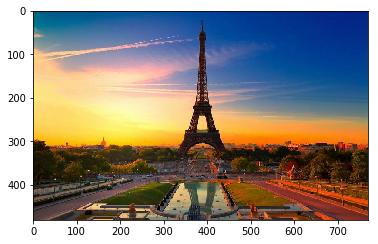

In [376]:
img = imread('./paris.jpg')
print(img.shape)

imgplot = plt.imshow(img)
plt.imsave("cv5_01.pdf", img)

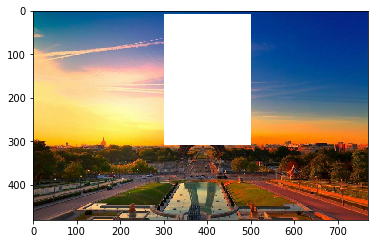

In [377]:
A_paris = np.array(img)

mask_paris = np.zeros((481, 770, 3))
mask_paris[10:310, 300:500, :] = 1

A_paris[mask_paris==1] = 255
imgplot = plt.imshow(A_paris)
plt.imsave("cv5_02.pdf", A_paris)

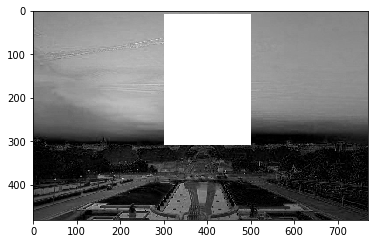

In [370]:
A_paris_p = A_paris[:,:,2]

imgplot = plt.imshow(A_paris_p, cmap='gray')

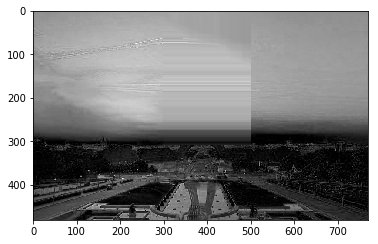

In [371]:
for i in range(9, 309):
    for j in range(299, 499):
        A = A_paris_p[i:(i+2), j:(j+2)]
#         print(i, j, A)
        x_ind = [[1, 1]]
        M = Partially_prescribed_matrix(A, x_ind)
        M.find_min_rank()
        if M.x_mr[0] is None or M.x_mr[0] == "any":
#             print("I'm here (0)!")
            A_paris_p[i+1, j+1] = abs(np.round((A.sum() - A[1, 1])/3).astype(int))
        else:
#             print("I'm here (1)!")
            A_paris_p[i+1, j+1] = round(M.x_mr[0])
            if A_paris_p[i+1, j+1] > 255:
#                 print("I'm here (2)!")
                A_paris_p[i+1, j+1] = 255
            elif A_paris_p[i+1, j+1] < 0:
                A_paris_p[i+1, j+1] = 0
            else:
                A_paris_p[i+1, j+1] = abs(round(M.x_mr[0]))
            if np.linalg.matrix_rank(A_paris_p[i:(i+2), j:(j+2)]) == 2:
#                 print("I'm here (2)!")
                A_paris_p[i+1, j+1] = abs(np.round((A.sum() - A[1, 1])/3).astype(int))
            elif A_paris_p[i+1, j+1] == 0:
#                 print("I'm here (2)!")
                A_paris_p[i+1, j+1] = abs(np.round((A.sum() - A[1, 1])/3).astype(int))
            elif A_paris_p[i+1, j+1] == 250:
#                 print("I'm here (2)!")
                A_paris_p[i+1, j+1] = abs(np.round((A.sum() - A[1, 1])/3).astype(int))
#         print(A_paris_p[i+1, j+1])
#         print("--------")
    
imgplot = plt.imshow(A_paris_p, cmap='gray')

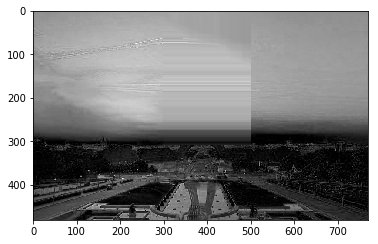

In [381]:
imgplot = plt.imshow(A_paris_p, cmap='gray')
imgplot = plt.imshow(A_paris_p, cmap='gray')
plt.imsave("cv5_03.pdf", A_paris_p, cmap='gray')

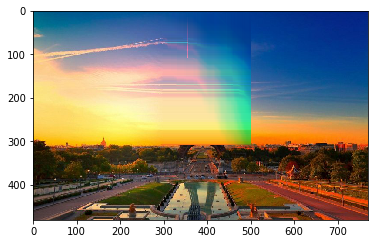

In [372]:
A_paris_r = np.concatenate((
               A_paris_r[:, :, 0].reshape(A_paris_r.shape[0],A_paris_r.shape[1], 1), 
               A_paris_r[:, :, 1].reshape(A_paris_r.shape[0],A_paris_r.shape[1], 1),
               A_paris_p.reshape(A_paris_r.shape[0],A_paris_r.shape[1], 1)),
               axis=2)
imgplot = plt.imshow(A_paris_r, cmap='gray')
plt.imsave("cv5_04.pdf", A_paris_r, cmap='gray')

In [379]:
plt.imsave("cv5_04.pdf", A_paris_r, cmap='gray')

In [ ]:
A_paris_p = A_paris[:,:,1]

imgplot = plt.imshow(A_paris_p, cmap='gray')

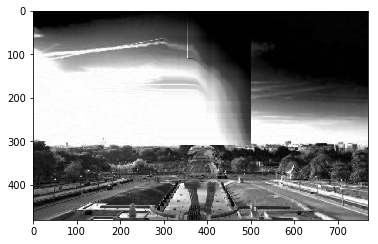

In [297]:
for i in range(308, 10, -1):
    for j in range(498, 499):
        A = A_paris_p[i:(i+2), j:(j+2)]
        x_ind = [[0, 0]]
        M = Partially_prescribed_matrix(A, x_ind)
        M.find_min_rank()
        if M.x_mr[0] is None or M.x_mr[0] == "any":
            A_paris_p[i, j] = abs(np.round((A.sum() - A[0, 0])/3).astype(int))
        else:
            A_paris_p[i, j] = abs(round(M.x_mr[0]))%256
            if np.linalg.matrix_rank(A_paris_p[i:(i+2), j:(j+2)]) == 2:
                A_paris_p[i, j] = abs(np.round((A.sum() - A[0, 0])/3).astype(int))
            elif A_paris_p[i, j] == 0:
                A_paris_p[i, j] = abs(np.round((A.sum() - A[0, 0])/3).astype(int))
            elif A_paris_p[i, j] == 255:
                A_paris_p[i, j] = abs(np.round((A.sum() - A[0, 0])/3).astype(int))
    
imgplot = plt.imshow(A_paris_p, cmap='gray')

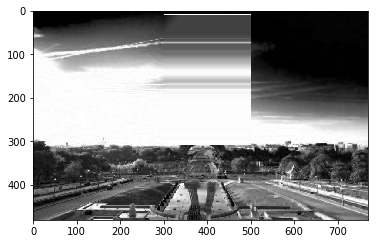

In [301]:
for i in range(308, 10, -1):
    for j in range(299, 499):
        A = A_paris_p[i:(i+2), j:(j+2)]
        x_ind = [[0, 1]]
        M = Partially_prescribed_matrix(A, x_ind)
        M.find_min_rank()
        if M.x_mr[0] is None or M.x_mr[0] == "any":
            A_paris_p[i, j+1] = abs(np.round((A.sum() - A[0, 1])/3).astype(int))
        else:
            A_paris_p[i, j+1] = abs(round(M.x_mr[0]))%256
            if np.linalg.matrix_rank(A_paris_p[i:(i+2), j:(j+2)]) == 2:
                A_paris_p[i, j+1] = abs(np.round((A.sum() - A[0, 1])/3).astype(int))
            elif A_paris_p[i, j+1] == 0:
                A_paris_p[i, j+1] = abs(np.round((A.sum() - A[0, 1])/3).astype(int))
            elif A_paris_p[i, j+1] == 255:
                A_paris_p[i, j+1] = abs(np.round((A.sum() - A[0, 1])/3).astype(int))
    
imgplot = plt.imshow(A_paris_p, cmap='gray')

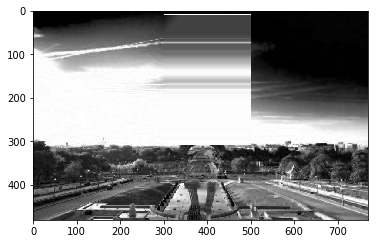

In [322]:

imgplot = plt.imshow(A_paris_p, cmap='gray')

9 498 : 1 1 1
10 498 : 2 255 128
11 498 : 2 66 34
12 498 : 1 66 34
13 498 : 1 66 34
14 498 : 1 66 34
15 498 : 2 66 34
16 498 : 1 66 34
17 498 : 0 66 33
18 498 : 0 66 33
19 498 : 0 66 33
20 498 : 0 66 33
21 498 : 0 66 33
22 498 : 0 66 33
23 498 : 0 66 33
24 498 : 0 66 33
25 498 : 0 66 33
26 498 : 0 66 33
27 498 : 0 66 33
28 498 : 0 66 33
29 498 : 0 66 33
30 498 : 0 66 33
31 498 : 0 66 33
32 498 : 1 66 34
33 498 : 1 66 34
34 498 : 0 66 33
35 498 : 0 66 33
36 498 : 0 66 33
37 498 : 0 66 33
38 498 : 0 66 33
39 498 : 0 66 33
40 498 : 0 66 33
41 498 : 0 66 33
42 498 : 0 66 33
43 498 : 0 66 33
44 498 : 0 66 33
45 498 : 0 66 33
46 498 : 0 66 33
47 498 : 0 66 33
48 498 : 0 66 33
49 498 : 0 66 33
50 498 : 0 66 33
51 498 : 0 66 33
52 498 : 0 66 33
53 498 : 0 66 33
54 498 : 1 66 34
55 498 : 1 66 34
56 498 : 1 68 34
57 498 : 1 68 34
58 498 : 1 68 34
59 498 : 2 71 36
60 498 : 1 75 38
61 498 : 1 74 38
62 498 : 0 73 36
63 498 : 0 75 38
64 498 : 0 146 73
65 498 : 1 94 48
66 498 : 1 87 44
67 498 : 1 79 

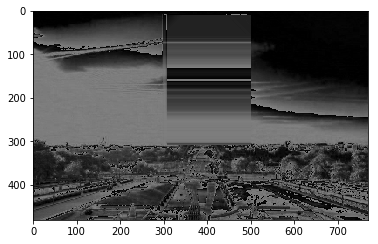

In [323]:
for i in range(9, 309):
    for j in range(498, 499):
        print(i, j, ":", A_paris_p_right[i, j], A_paris_p[i, j], 
              np.round((A_paris_p_right[i, j].astype(int) + A_paris_p[i, j].astype(int))/2, 0).astype(int)%256)
        A_paris_r[i, j] = np.round((A_paris_p_right[i, j].astype(int) + A_paris_p[i, j].astype(int))/2%256)

imgplot = plt.imshow(A_paris_r, cmap='gray')

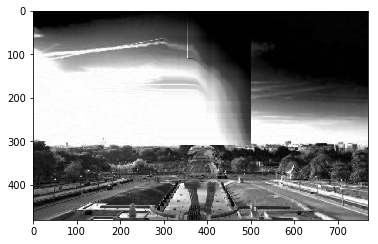

In [296]:
# A_paris_p_left = A_paris_p.copy()
imgplot = plt.imshow(A_paris_p_left, cmap='gray')

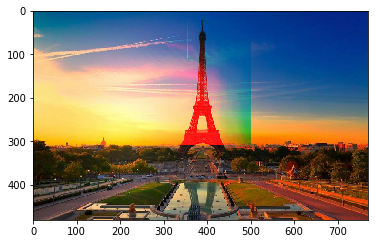

In [198]:
A_paris_r = A_paris_p.copy()
A_paris_r = np.concatenate((A_paris_r.reshape(A_paris_r.shape[0],A_paris_r.shape[1], 1), 
               img[:,:,1].reshape(A_paris_r.shape[0],A_paris_r.shape[1], 1),
               img[:,:,2].reshape(A_paris_r.shape[0],A_paris_r.shape[1], 1)),
               axis=2)
imgplot = plt.imshow(A_paris_r, cmap='gray')
plt.imsave("cv4_04.pdf", A_paris_r, cmap='gray')

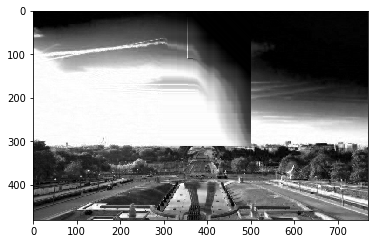

In [182]:
for i in range(309, 9, -1):
    for j in range(299, 499):
        A = A_paris_p[i:(i+2), j:(j+2)]
#         print(i, j, A)
        x_ind = [[1, 1]]
        M = Partially_prescribed_matrix(A, x_ind)
        M.find_min_rank()
        if M.x_mr[0] is None or M.x_mr[0] == "any":
#             print("I'm here (0)!")
            A_paris_p[i+1, j+1] = abs(np.round((A.sum() - A[1, 1])/3).astype(int))
        else:
#             print("I'm here (1)!")
            A_paris_p[i+1, j+1] = abs(round(M.x_mr[0]))%256
            if np.linalg.matrix_rank(A_paris_p[i:(i+2), j:(j+2)]) == 2:
#                 print("I'm here (2)!")
                A_paris_p[i+1, j+1] = abs(np.round((A.sum() - A[1, 1])/3).astype(int))
            elif A_paris_p[i+1, j+1] == 0:
#                 print("I'm here (2)!")
                A_paris_p[i+1, j+1] = abs(np.round((A.sum() - A[1, 1])/3).astype(int))
#         print(A_paris_p[i+1, j+1])
#         print("--------")
    
imgplot = plt.imshow(A_paris_p, cmap='gray')

In [197]:
A = A_paris_p[i:(i+2), j:(j+2)]
x_ind = [[1, 1]]
        M = Partially_prescribed_matrix(A, x_ind)
        M.find_min_rank()
        if M.x_mr[0] is None or M.x_mr[0] == "any":
            A_paris_p[i+1, j+1] = abs(np.round((A.sum() - A[1, 1])/3).astype(int))
        else:
            A_paris_p[i+1, j+1] = abs(round(M.x_mr[0]))
            if np.linalg.matrix_rank(A_paris_p[i:(i+2), j:(j+2)]) == 2:
                A_paris_p[i+1, j+1] = abs(np.round((A.sum() - A[1, 1])/3).astype(int))
    
imgplot = plt.imshow(A_paris_p, cmap='gray')

IndentationError: unexpected indent (<ipython-input-197-76d98df378ef>, line 3)